In [73]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from collections import defaultdict
from ultralytics import YOLO
from scipy import stats
from tqdm import tqdm
from PIL import Image


# Preprocesamiento

In [9]:
# Metadata para ordenar el entrenamiento
metadata_path = 'datasets\Labeled Stomatal Images.csv'
metadata = pd.read_csv(metadata_path)

In [10]:
#Mediciones 1 plant-out
def onePlantOut(plant_name):
  main_folder = 'datasets'

  train_images_folder = os.path.join(main_folder, 'train/images')
  train_labels_folder = os.path.join(main_folder, 'train/labels')
  val_images_folder = os.path.join(main_folder, 'val/images')
  val_labels_folder = os.path.join(main_folder, 'val/labels')

  folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
  for folder in folders:
      if not os.path.exists(folder):
          os.makedirs(folder)

  # Seleccionar la planta a medir su rendimiento
  plant = plant_name
  trainFiles = metadata[metadata['Species'] != plant]['FileName'].tolist()
  valFiles = metadata[metadata['Species'] == plant]['FileName'].tolist()

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in trainFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in valFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))

def holdOut(random_seed = 42, test_size = 0.2):
    random.seed(random_seed)
    main_folder = 'datasets'

    train_images_folder = os.path.join(main_folder, 'train/images')
    train_labels_folder = os.path.join(main_folder, 'train/labels')
    val_images_folder = os.path.join(main_folder, 'val/images')
    val_labels_folder = os.path.join(main_folder, 'val/labels')

    folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Obtener todos los archivos de la columna 'FileName'
    all_files = metadata['FileName'].tolist()

    # Mezclar aleatoriamente los archivos
    random.shuffle(all_files,)

    split_idx = int((1-test_size) * len(all_files))
    trainFiles = all_files[:split_idx]
    valFiles = all_files[split_idx:]

    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in trainFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))
    
    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in valFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))
                    
def plot_detections(results):
    img_rgb = cv2.cvtColor(results.orig_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_rgb)
    for box, score in zip(results.boxes.xyxy, results.boxes.conf):
        x1, y1, x2, y2 = box
        # Coordenadas deben ser ints
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Mostrar el score como etiqueta en la esquina superior izquierda de la caja
        label = f"{score:.2f}"  # Formatear el score a 2 decimales
        ax.text(x1, y1, label, color='white', fontsize=5, verticalalignment='top', bbox={'color': 'r', 'pad': 0})
        
    plt.show()

def show_image(image_path, txt_path):
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Leer y mostrar el contenido del archivo .txt
    with open(txt_path, 'r') as file:
        annotations = file.readlines()

    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        x = (x_center - width / 2) * img.shape[1]
        y = (y_center - height / 2) * img.shape[0]
        w = width * img.shape[1]
        h = height * img.shape[0]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

# Test

In [11]:
# Elegir el tipo de preprocesamiento
holdOut(random_seed = 42, test_size = 0.2)
# onePlantOut("Nuttall oak")

model8 = YOLO('Modelos\yolov8\HoldOutSimpleYolov8n.pt')
model8Adjust = YOLO('Modelos\yolov8\HoldOutAdjustYolov8n.pt')
model10 = YOLO('Modelos\yolov10\HoldOutSimpleYolov10n.pt')
model10Adjust = YOLO('Modelos\yolov10\HoldOutAdjustYolov10n.pt')

## Test visual


image 1/1 c:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\images\STMHD0007.jpg: 480x640 67 stoma1s, 60 stoma2s, 85.7ms
Speed: 3.0ms preprocess, 85.7ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)


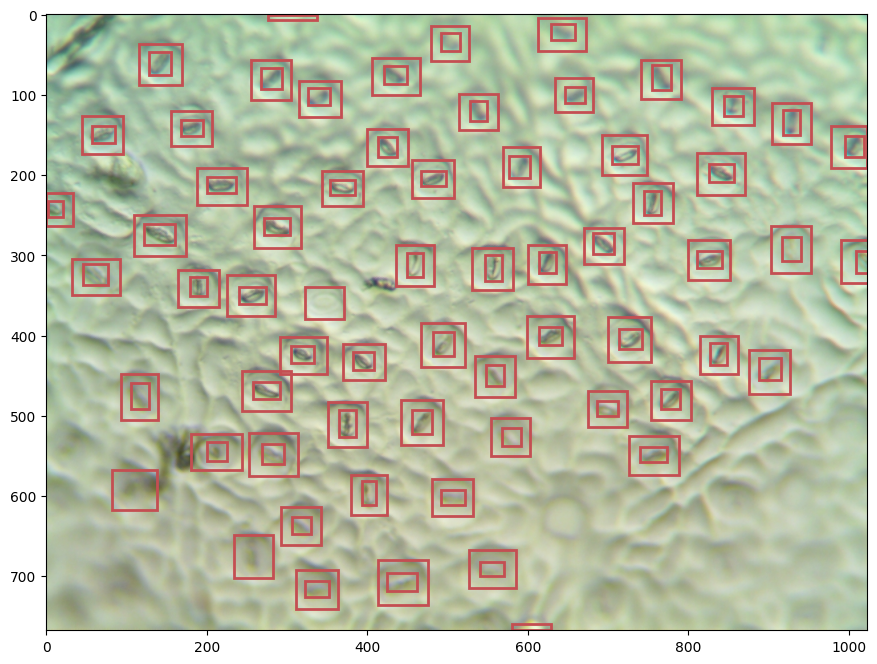

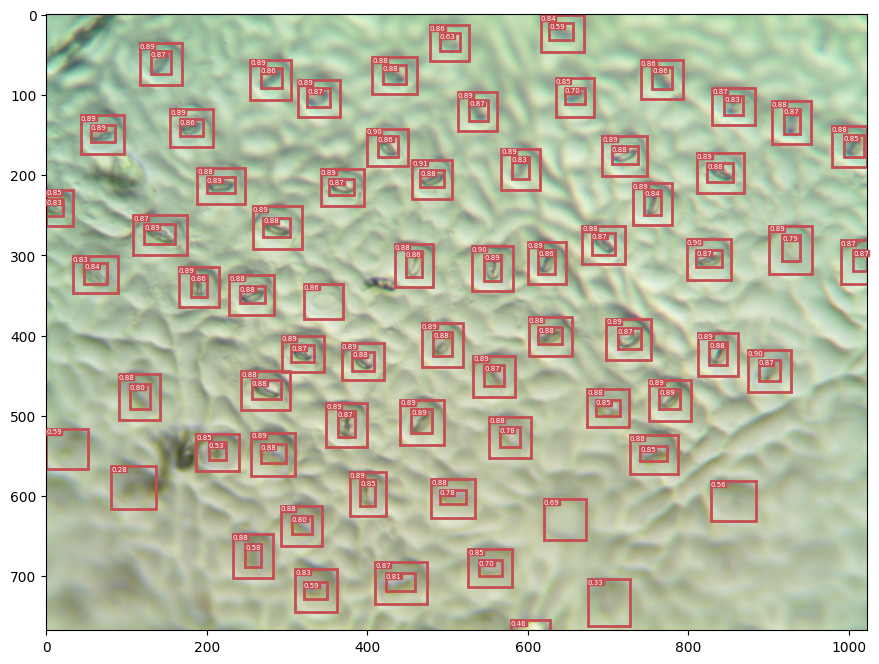

In [12]:
PATH_images = "datasets/val/images"
PATH_labels = "datasets/val/labels"
plant_type = '/STMHD'
number = "0007"
image_path = f"{PATH_images}{plant_type}{number}.jpg"
txt_path = f"{PATH_labels}{plant_type}{number}.txt"

results = model8.predict(image_path)[0]

show_image(image_path, txt_path)
plot_detections(results)

## Test métricas


In [13]:
results8 = model8.val(data='YOLO8INFO.yaml', save_json=False)
results8Adjust = model8Adjust.val(data='YOLO8INFO.yaml', save_json=False)
results10 = model10.val(data='YOLO8INFO.yaml', save_json=False)
results10Adjust = model10Adjust.val(data='YOLO8INFO.yaml', save_json=False)


Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 134/134 [00:53<00:00,  2.50it/s]


                   all       2143     163185      0.968      0.964      0.991      0.834
                stoma1       2143      99280      0.973      0.965      0.992      0.854
                stoma2       1807      63905      0.964      0.963       0.99      0.815
Speed: 0.1ms preprocess, 2.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val4
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 134/134 [00:53<00:00,  2.50it/s]


                   all       2143     163185      0.969      0.965      0.991      0.819
                stoma1       2143      99280      0.974      0.967      0.992      0.841
                stoma2       1807      63905      0.964      0.964       0.99      0.797
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\val5
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLOv10n summary (fused): 285 layers, 2,695,196 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 134/134 [00:51<00:00,  2.58it/s]


                   all       2143     163185      0.967      0.961       0.99      0.835
                stoma1       2143      99280      0.974      0.961      0.992      0.854
                stoma2       1807      63905      0.959      0.961      0.989      0.816
Speed: 0.1ms preprocess, 3.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\val6
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLOv10n summary (fused): 285 layers, 2,695,196 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 134/134 [00:51<00:00,  2.58it/s]


                   all       2143     163185      0.962      0.958       0.99      0.822
                stoma1       2143      99280      0.968      0.953       0.99       0.84
                stoma2       1807      63905      0.956      0.963      0.989      0.804
Speed: 0.1ms preprocess, 3.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\val7


# Contador

In [69]:
def count_bounding_boxes(model, image_path):
    results = model.predict(image_path, verbose=False)

    bbox_counts = defaultdict(int)

    for result in results:
        for box in result.boxes: 
            class_id = int(box.cls) 
            bbox_counts[class_id] += 1

    return bbox_counts

def load_labels(label_path):
    labels = defaultdict(list)
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            labels[class_id].append(bbox)
    return labels

def calculate_differences(pred_counts, real_counts):
    differences = {} 

    all_classes = set(pred_counts.keys()).union(set(real_counts.keys()))

    for class_id in all_classes:
        real_count = real_counts.get(class_id, 0)
        pred_count = pred_counts.get(class_id, 0)

        difference = pred_count - real_count
        differences[class_id] = difference

    return differences


def compare_predictions_with_labels(model, image_path, label_path):

    pred_counts = count_bounding_boxes(model, image_path)

    real_labels = load_labels(label_path)

    real_counts = {class_id: len(bboxes) for class_id, bboxes in real_labels.items()}

    differences_by_class = calculate_differences(pred_counts, real_counts)

    return differences_by_class


In [70]:
image_dir = 'datasets/val/images'
label_dir = 'datasets/val/labels'

images = [img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png'))]

for image_name in images[:1]:
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))
    differences_by_class = compare_predictions_with_labels(model8, image_path, label_path)
print(differences_by_class)

{0: 3, 1: 1}


In [72]:
image_dir = 'datasets/val/images'
label_dir = 'datasets/val/labels'

images = [img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png'))]

differences8 = []
differences8Adjust = []
differences10 = []
differences10Adjust = []

for image_name in tqdm(images):
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))
    differences8_by_class = compare_predictions_with_labels(model8, image_path, label_path)
    differences8.append(differences8_by_class)
    differences8Adjust_by_class = compare_predictions_with_labels(model8Adjust, image_path, label_path)
    differences8Adjust.append(differences8Adjust_by_class)
    differences10_by_class = compare_predictions_with_labels(model10, image_path, label_path)
    differences10.append(differences10_by_class)
    differences10Adjust_by_class = compare_predictions_with_labels(model10Adjust, image_path, label_path)
    differences10Adjust.append(differences10Adjust_by_class)


100%|██████████| 2143/2143 [05:35<00:00,  6.39it/s]


In [74]:
def calculate_statistics(differences):
    media = np.mean(differences)
    mediana = np.median(differences)
    desviacion_estandar = np.std(differences)
    varianza = np.var(differences)
    rango = np.ptp(differences)
    minimo = np.min(differences)
    maximo = np.max(differences)
    sesgo = stats.skew(differences)
    curtosis = stats.kurtosis(differences)
    
    return {
        "media": media,
        "mediana": mediana,
        "desviacion_estandar": desviacion_estandar,
        "varianza": varianza,
        "rango": rango,
        "minimo": minimo,
        "maximo": maximo,
        "sesgo": sesgo,
        "curtosis": curtosis
    }
def flatten_differences_by_class(differences):
    class_differences = defaultdict(list)
    for diff in differences:
        for class_id, value in diff.items():
            class_differences[class_id].append(value)
    return class_differences

def calculate_and_print_stats_by_class(flat_differences):
    for class_id, diffs in flat_differences.items():
        stats_by_class = calculate_statistics(diffs)
        print(f"Clase {class_id}:")
        print(stats_by_class)
        print()

flat_differences8 = flatten_differences_by_class(differences8)
flat_differences8Adjust = flatten_differences_by_class(differences8Adjust)
flat_differences10 = flatten_differences_by_class(differences10)
flat_differences10Adjust = flatten_differences_by_class(differences10Adjust)

print("Métricas estadísticas por clase para model8:")
calculate_and_print_stats_by_class(flat_differences8)

print("Métricas estadísticas por clase para model8Adjust:")
calculate_and_print_stats_by_class(flat_differences8Adjust)

print("Métricas estadísticas por clase para model10:")
calculate_and_print_stats_by_class(flat_differences10)

print("Métricas estadísticas por clase para model10Adjust:")
calculate_and_print_stats_by_class(flat_differences10Adjust)

Métricas estadísticas por clase para model8:
Clase 0:
{'media': 0.9295380307979468, 'mediana': 0.0, 'desviacion_estandar': 2.8153933444413473, 'varianza': 7.9264396839246345, 'rango': 43, 'minimo': -7, 'maximo': 36, 'sesgo': 3.7764537653466914, 'curtosis': 30.326678728388075}

Clase 1:
{'media': 1.698174006444683, 'mediana': 1.0, 'desviacion_estandar': 3.366318750342194, 'varianza': 11.33210192890543, 'rango': 37, 'minimo': -5, 'maximo': 32, 'sesgo': 2.5721472544961874, 'curtosis': 10.981376045668727}

Métricas estadísticas por clase para model8Adjust:
Clase 0:
{'media': 1.0718618758749416, 'mediana': 1.0, 'desviacion_estandar': 2.686352128941726, 'varianza': 7.216487760669743, 'rango': 41, 'minimo': -7, 'maximo': 34, 'sesgo': 3.2584814136647653, 'curtosis': 23.79499662415966}

Clase 1:
{'media': 1.5293484114162628, 'mediana': 1.0, 'desviacion_estandar': 3.2022685240880415, 'varianza': 10.254523700365004, 'rango': 39, 'minimo': -5, 'maximo': 34, 'sesgo': 2.8953081161416456, 'curtosis':